In [1]:
from multiinstance.gradientMethod import g1, initRealDS, addEsts, plotResults
from glob import glob
import numpy as np
from tqdm.notebook import tqdm
from multiinstance.data.realData import buildDataset
import matplotlib.pyplot as plt
# from multiinstance.distanceApproaches import addTransformScores,getTransformScores
from multiinstance.utils import *
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
def plotGlobalEstResults(dsi):
    fig,ax = plt.subplots(1,2,figsize=(16,4))
    trueGlobalClassPrior = dsi.trueAlphas.flatten().dot(dsi.numU) / dsi.numU.sum()
    ax[0].vlines(trueGlobalClassPrior, 0, 1, color="red",alpha=.5,label=r"$\alpha_c$")
    ax[0].fill_between(np.quantile(dsi.globalAlphaHats,[0,1]),0,1,color="blue",alpha=.5)
#     ax[0].vlines(dsi.globalAlphaHats.mean(), 0, .5, color="blue",alpha=.5,label=r"$\hat{\alpha_c}$")
    ax[0].set_xlim(-.10,1)
    ax[0].legend(bbox_to_anchor=(1.05,1),loc="upper right")
    plt.show()

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/thyroid.mat


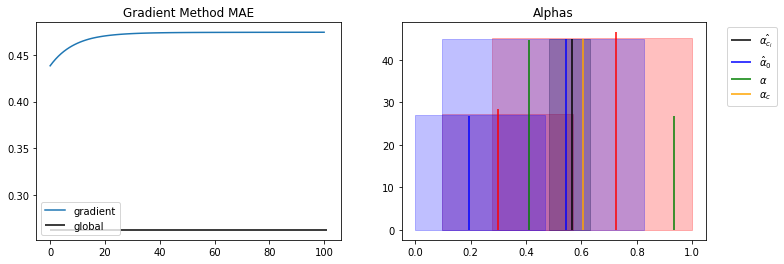

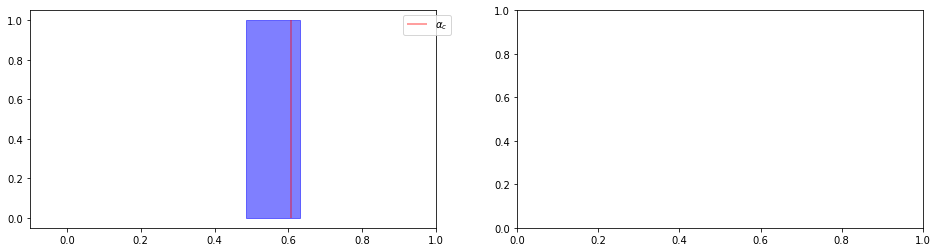

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/pageblock.mat


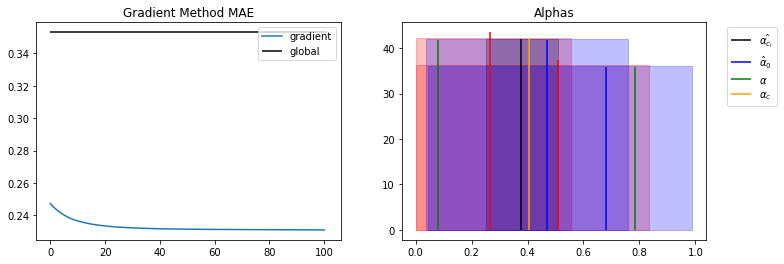

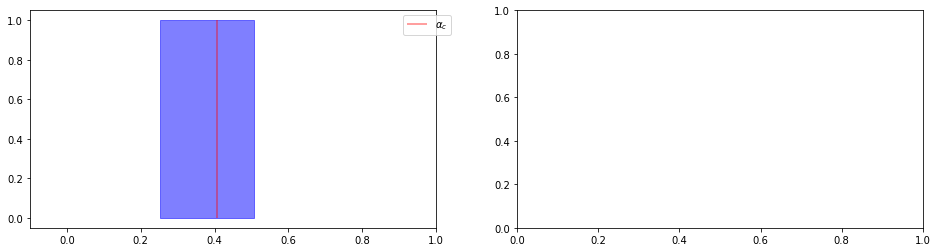

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/pima.mat


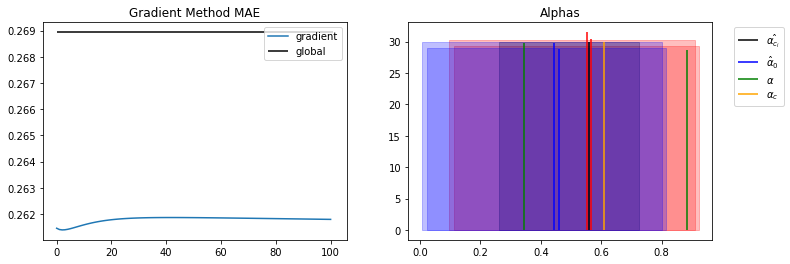

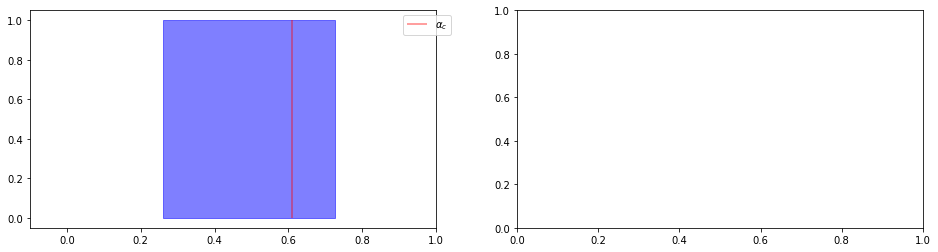

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/mol_bio.mat


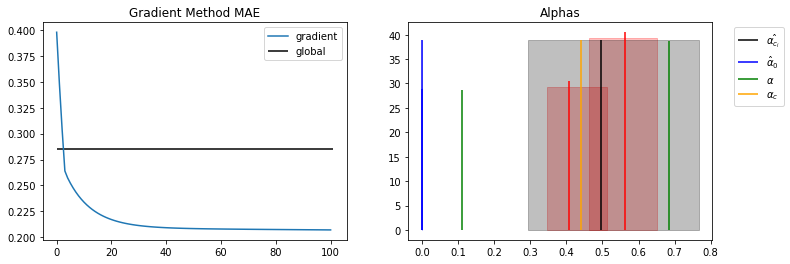

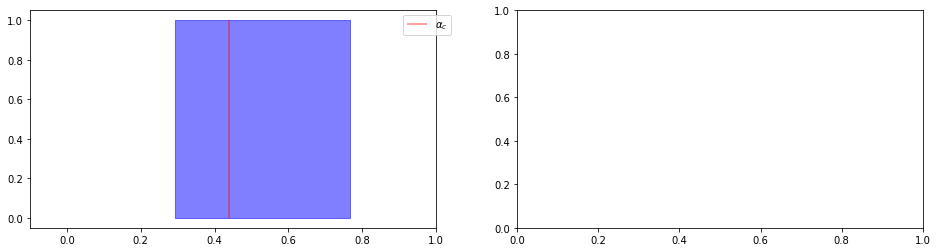

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/pendigit.mat


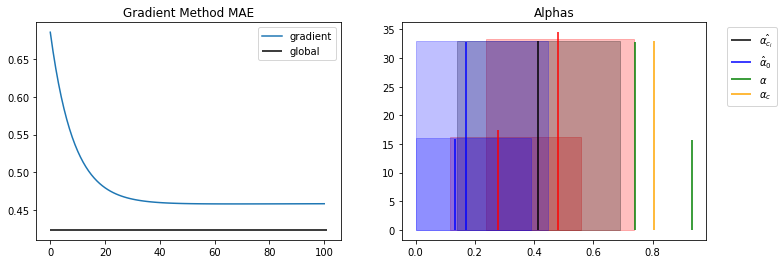

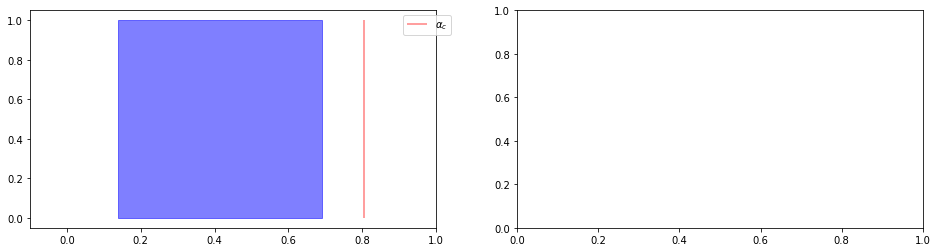

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/waveformnoise.mat


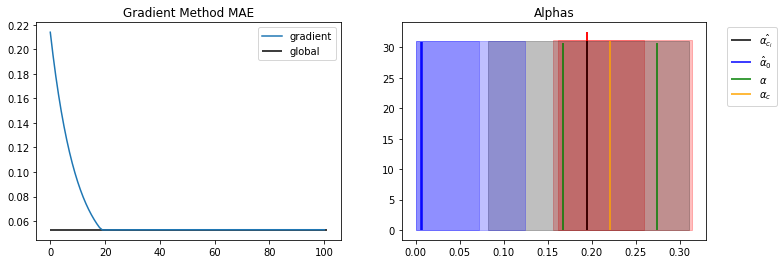

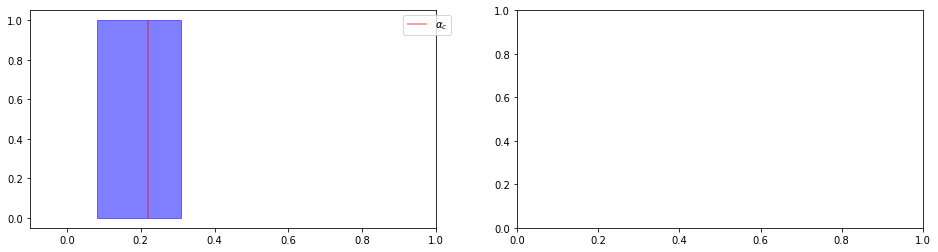

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/parkinsons.mat


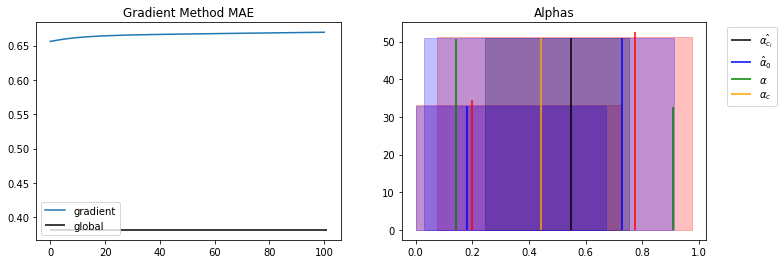

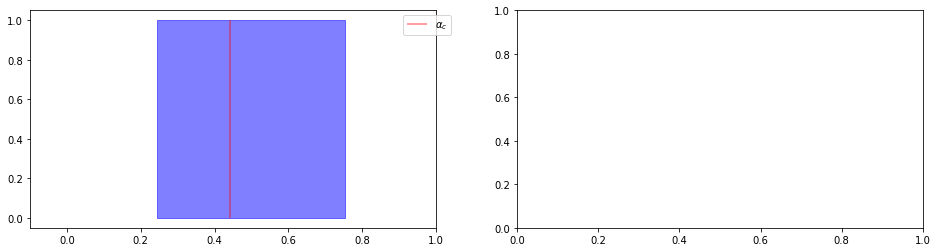

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/anuran.mat


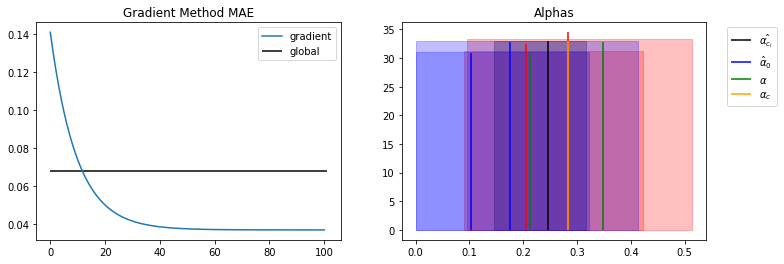

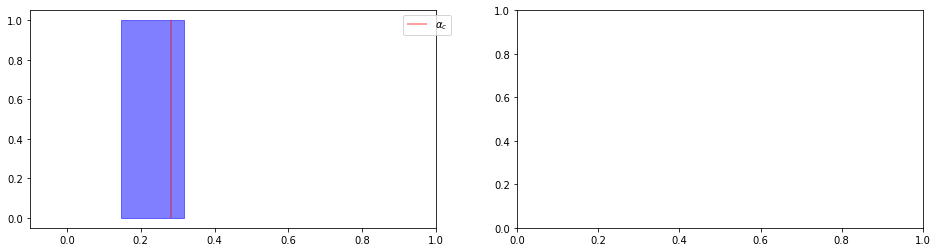

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/covertype.mat


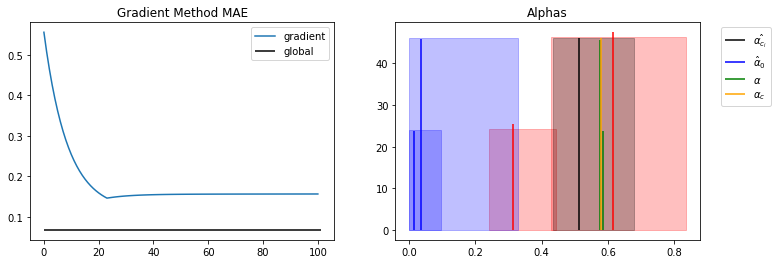

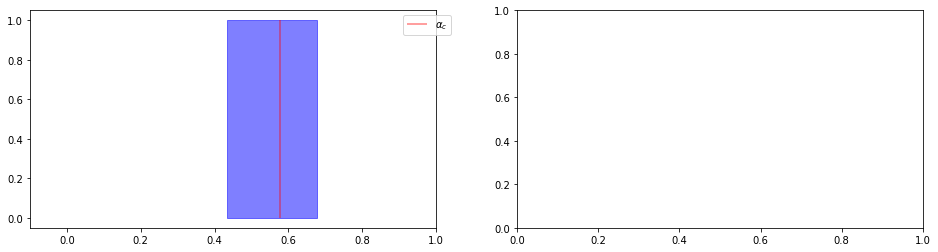

/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/airfoil.mat


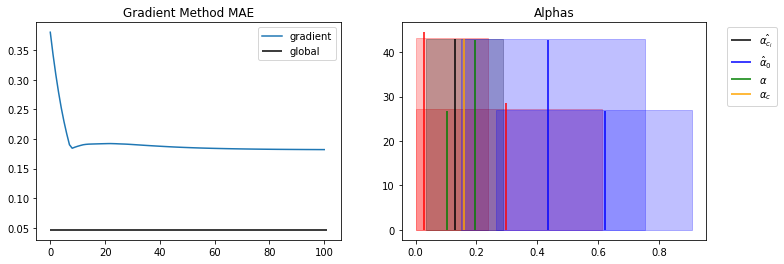

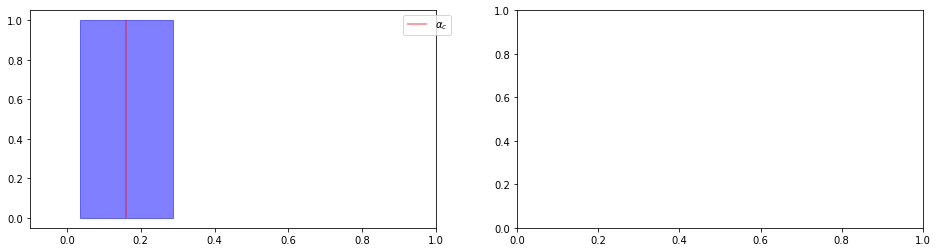

In [3]:
globalEstAES =[]
localEstAES = []
ae0,ae1,bae,lae = 0, 0, 0, 0
N = 0
datasets = []
results = []
# fileNames = glob("/home/dzeiberg/ClassPriorEstimation/rawDatasets/*.mat")[1:]
fileNames = [g for g in glob("/ssdata/ClassPriorEstimationPrivate/data/rawDatasets/*.mat") if "mushroom" not in g]
fileNames = [fileNames[i] for i in np.random.choice(np.arange(len(fileNames)),replace=False, size=10)]

for fileName in tqdm(fileNames, total=len(fileNames),desc="reps"):
    name = fileName.split("/")[-1].replace(".mat","")
    print(fileName)
    # build dataset
    size = 2
    n_epochs = 100
    dsi = buildDataset(fileName,size=size,alphaDistr=lambda: np.random.uniform(0.05,.95))
    dsi = addTransformScores(dsi,)
    dsi = addGlobalEsts(dsi,reps=10)
    dsi = addBagAlphaHats(dsi,reps=50)
    dsi.trueGlobalClassPrior = dsi.trueAlphas.flatten().dot(dsi.numU) / dsi.numU.sum()
    globalEstAES.append(np.abs(dsi.trueGlobalClassPrior - dsi.globalAlphaHats.mean()))
    localEstAES.append(np.abs(dsi.trueAlphas.flatten() - dsi.alphaHats.mean(1)))
#     # Run gradient method
    g1Results = g1(dsi,n_epochs=n_epochs, varLambda=0, anchorLambda=0, regLambda=0, wOneLambda=0.1)
    plotResults(dsi,g1Results)
    plotGlobalEstResults(dsi)
    ae0 += g1Results["maes"][-1] * dsi.N
    bae += g1Results["baseline_mae"] * dsi.N
    lae += g1Results["maes"][0] * dsi.N
    N += dsi.N
    datasets.append(dsi)
    results.append(g1Results)

Text(0.5, 0, 'Transform AUCPU')

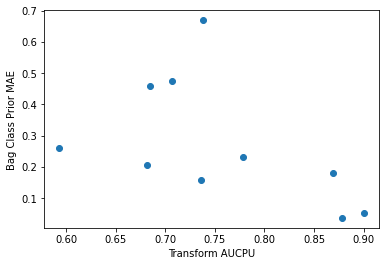

In [4]:
plt.scatter([d.aucPU for d in datasets], [r["maes"][-1] for r in results])
plt.ylabel("Bag Class Prior MAE")
plt.xlabel("Transform AUCPU")

Text(0, 0.5, 'Bag Class Prior MAE')

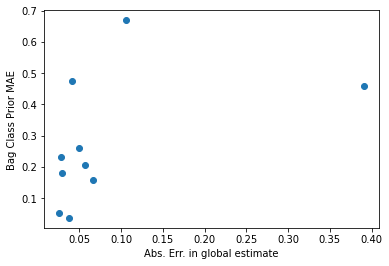

In [5]:
plt.scatter(globalEstAES, [r["maes"][-1] for r in results])
plt.xlabel("Abs. Err. in global estimate")
plt.ylabel("Bag Class Prior MAE")

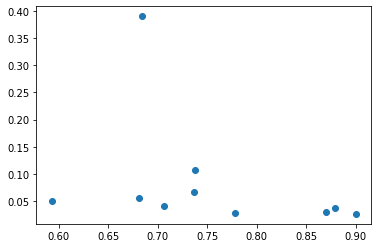

In [6]:
plt.scatter([d.aucPU for d in datasets], globalEstAES)

In [7]:
np.mean(globalEstAES)

0.08301339408725564

In [8]:
np.mean(localEstAES)

0.39774031792862374

In [9]:
print(" Gradient Method: {:.3f}\n Global Baseline: {:.3f}\n  Local Baseline: {:.3f}".format(ae0/N, bae/N, lae/N))

 Gradient Method: 0.273
 Global Baseline: 0.221
  Local Baseline: 0.398


In [10]:
((lae/N) - (ae0/N)) / (lae/N)

0.3134281351995674

## ROC Curve